In [1]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

In [2]:
from GRU_pipeline import DataHolder, paths
DH = DataHolder(**paths)

In [3]:
DH._unused_index

Int64Index([8196, 2053, 8206, 8219, 2079, 4127, 2083, 2094, 2095, 2096,
            ...
            2004, 4055, 2011, 8161, 2028, 2034, 8953, 4884, 6135, 2045],
           dtype='int64', length=798)

In [4]:
#import embeds
path_to_embeds = "data/final/text/embeds"
embeds = pd.read_feather(path_to_embeds)

#import openface data
openface_spk_1_path = "data/final/openface/openface_speaker_1_05_by_05"
openface_spk_2_path = "data/final/openface/openface_speaker_2_05_by_05"
openface_spk_1 = pd.read_feather(openface_spk_1_path)
openface_spk_2 = pd.read_feather(openface_spk_2_path)

openface_spk_1_dict_path = "data/final/openface/openface_speaker_1_dict_utt_to_frame.txt"
openface_spk_2_dict_path = "data/final/openface/openface_speaker_2_dict_utt_to_frame.txt"
with open(openface_spk_1_dict_path, "r") as fp:
    openface_spk_1_dict = json.load(fp)
with open(openface_spk_2_dict_path, "r") as fp:
    openface_spk_2_dict = json.load(fp)

#import opensmile data
opensmile_spk_1_path = "data/final/opensmile/opensmile_speaker_1_05_by_05"
opensmile_spk_2_path = "data/final/opensmile/opensmile_speaker_2_05_by_05"
opensmile_spk_1 = pd.read_feather(opensmile_spk_1_path)
opensmile_spk_2 = pd.read_feather(opensmile_spk_2_path)

opensmile_spk_1_dict_path = "data/final/opensmile/opensmile_speaker_1_dict_utt_to_frame.txt"
opensmile_spk_2_dict_path = "data/final/opensmile/opensmile_speaker_2_dict_utt_to_frame.txt"
with open(opensmile_spk_1_dict_path, "r") as fp:
    opensmile_spk_1_dict = json.load(fp)
with open(opensmile_spk_2_dict_path, "r") as fp:
    opensmile_spk_2_dict = json.load(fp)

#filter dicts
def filter_dict(dic:dict, max_len=30)->dict:
    """Filters on 0<len(value)<max_len"""
    return {key:value for (key,value) in dic.items() if len(value) in range(1,max_len)}

openface_spk_1_dict = filter_dict(openface_spk_1_dict)
openface_spk_2_dict = filter_dict(openface_spk_2_dict)
opensmile_spk_1_dict = filter_dict(opensmile_spk_1_dict)
opensmile_spk_2_dict = filter_dict(opensmile_spk_2_dict)

In [5]:
train_test = DH.stratify_embeds(speaker=1)
train_dict = {k:v for (k,v) in DH.openface_spk_1_dict.items() if int(k) in train_test['train']}
test_dict = {k:v for (k,v) in DH.openface_spk_1_dict.items() if int(k) in train_test['test']}

In [6]:
X = torch.from_numpy(DH.openface_spk_1[DH.openface_col].values).to(torch.float32)
y = torch.from_numpy(DH.embeds[DH.target_col].values).to(torch.float32)

In [7]:
from GRU_pipeline import dicDataset, pad_collate

train_set = dicDataset(train_dict,X,y)
test_set = dicDataset(test_dict,X,y)

In [8]:
y.shape

torch.Size([10134, 5])

In [12]:
from torch.nn.utils.rnn import pad_packed_sequence

class GRUModel(nn.Module):
    def __init__(self, input_dim=17, hidden_dim=8, layer_dim=3, output_dim=5, dropout_prob=.1):
        super(GRUModel, self).__init__()

        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, dropout=dropout_prob, batch_first = True
        )

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.s = nn.Sigmoid()

    def forward(self, x_packed):

        x, hidden = self.gru(x_packed)

        x,l = pad_packed_sequence(x, batch_first=True)

        out = torch.stack([x[i][l[i]-1] for i in range(x.shape[0])])

        out = self.fc(out)
        out = self.s(out)

        return out

In [37]:
#model = GRUModel()

dataloader = DataLoader(train_set, batch_size = 100, shuffle = True, collate_fn = pad_collate)
testloader = DataLoader(train_set, batch_size = len(test_dict), shuffle = True, collate_fn = pad_collate)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def eval_on_test():
    model.eval()
    tot_loss=0.0
    for batch in testloader:
        with torch.no_grad():
            pred = model(batch['features'])
        loss = criterion(batch['targets'], pred)
        tot_loss += loss / pred.shape[0]
    return loss

hist_train_loss = []
hist_test_loss = []

for epoch in range(30):
    model.train()

    epoch_loss = 0.0

    for batch in dataloader:

        pred = model(batch['features'])
        loss = criterion(batch['targets'], pred)

        epoch_loss += loss / pred.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    hist_train_loss.append(loss)
    
    hist_test_loss.append(eval_on_test())

hist_train_loss = [x.detach().numpy() for x in hist_train_loss]
hist_test_loss = [x.detach().numpy() for x in hist_test_loss]

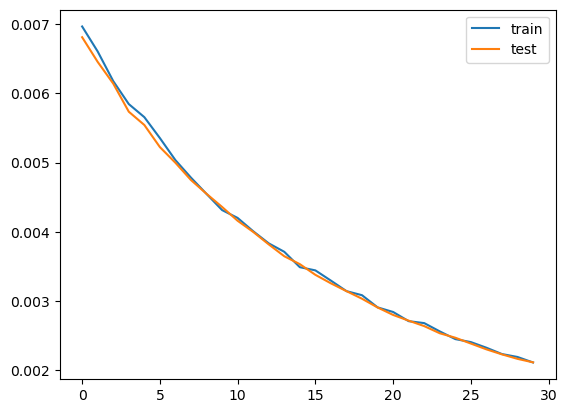

In [38]:
plt.plot(hist_train_loss, label='train')
plt.plot(hist_test_loss, label='test')
plt.legend()
plt.show()

In [7]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence

class monDataset(Dataset):
    def __init__(self, dic, X, y, max_len=None):

        self.index = list(dic.keys())
        self.dic = dic
        self.X = X
        self.Y = y
        self.keys = list(dic.keys())
        #if not max_len : max_len = min(33,max([len(v) for v in dic.keys()]))
        #self.max_len_tensor = torch.zeros((max_len,X.shape[1]))
    
    def __len__(self):
        return len(self.dic)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        features_indexes = self.dic[str(self.keys[idx])]
        features = X[features_indexes, :]

        # features_length = len(features_indexes)
        targets = torch.tensor(y[idx])
        # print(features)
        # print(features_length)
        # print(targets)
        # features_length, 
        
        #output = {
        #    'features':features,
        #    'targets':targets,
        #    'lenght':len(features_indexes)
        #}

        return features, targets, len(features_indexes)

def pad_collate(batch):
    f,t,l = [*zip(*batch)]
    output = {
        'features':pack_padded_sequence(pad_sequence(f,batch_first=True), l, batch_first=True, enforce_sorted=False),
        'targets':torch.stack(t)
    }
    return output

#train_dataset = monDataset(training_dict_A, X_train, y_train) #input 23 features, output 5 cats
#test_dataset = monDataset(test_dict_A, X_test, y_test) #input 23 features, output 5 cats
#
#train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, collate_fn = pad_collate)
#test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle = True, collate_fn = pad_collate)

DS = monDataset(openface_index_A,X,y) #getittem gives dict

DL = DataLoader(DS, batch_size = 30, shuffle = True, collate_fn = pad_collate)

NameError: name 'openface_index_A' is not defined

In [ ]:
def train_model(model, DS, train_set, test_set, class_weights, batch_size=20, num_epochs=10, lr=0.01):

    train_loss=[]
    test_loss=[]

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):

        shuffle(train)

        model.train()

        epoch_average_loss = 0.0

        batch_loss=0.0

        for i in train_set:

            x,y = DS[i]

            if len(x)==0:continue

            y_pre = model(x)
            batch_loss+=criterion(y_pre, y)

            if i%batch_size==0:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()
                epoch_average_loss += batch_loss.item() * batch_size / len(train_set)
                batch_loss=0.0

        train_loss.append(epoch_average_loss)
        test_loss.append(test_model(model, criterion, DS, test_set))

    return train_loss, test_loss

def test_model(model,criterion, DS, test_set):
    model.eval()
    loss = 0.0
    for i in test_set:
        x,y = DS[i]
        if len(x)==0:continue
        y_pre = model(x)
        loss+=criterion(y_pre, y)
    return loss

In [ ]:
def train_model(model, train_loader, test_loader, class_weights, device, batch_size = 8, num_epochs=10, lr=0.01):

    train_loss=[]
    test_loss=[]

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):

        model.train()

        epoch_average_loss = 0.0

        for data in train_loader:

            features, targets = data
            targets = torch.tensor(targets, dtype = torch.long).to(device)
            features = features.to(device)
            output = model(features)

            batch_loss = criterion(output, targets)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            epoch_average_loss += batch_loss.item() * batch_size / len(train_dataloader)

        train_loss.append(epoch_average_loss)
        test_loss.append(test_model(model, criterion, test_loader, lr, len(train_dataloader)))

    return train_loss, test_loss

def test_model(model,criterion, test_dataloader, lr, batch_size = 8, train_len = 0):
    model.eval()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    epoch_average_loss = 0.0
    for i, data in enumerate(test_dataloader):
        features, targets = data
        targets = torch.tensor(targets, dtype = torch.long).to(device)
        features = features.to(device)
        output = model(features)
        batch_loss = criterion(output, targets)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        epoch_average_loss += batch_loss.item() * batch_size / len(test_dataloader)
    return epoch_average_loss

In [ ]:
from models import AudioGRU

In [ ]:
device = torch.device("mps")

rnn = AudioGRU().to(device)
train_loss, test_loss = train_model(rnn, train_dataloader, test_dataloader, class_weights, device, batch_size = 8, num_epochs = 20, lr = 0.02)

/var/folders/l7/1yhnrkcx2f79z5dph4rg3h540000gn/T/ipykernel_5217/4181217194.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y[idx])
/var/folders/l7/1yhnrkcx2f79z5dph4rg3h540000gn/T/ipykernel_5217/295638334.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype = torch.long).to(device)
/var/folders/l7/1yhnrkcx2f79z5dph4rg3h540000gn/T/ipykernel_5217/295638334.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype = torch.long).to(device)


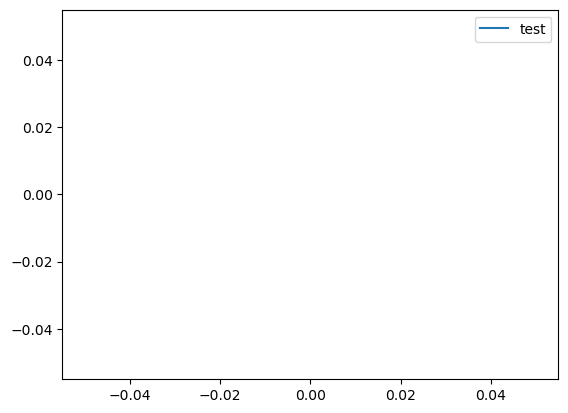

In [ ]:
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

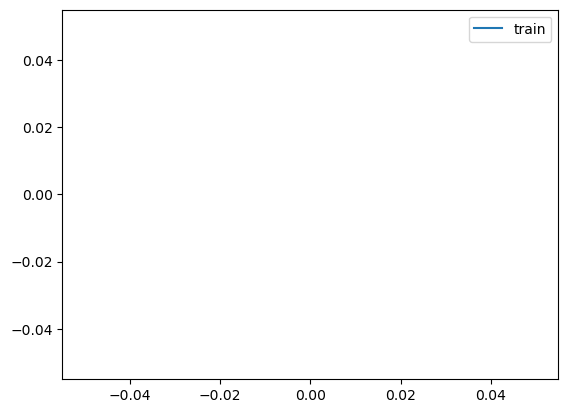

In [ ]:
plt.plot(train_loss, label='train')
plt.legend()
plt.show()

In [ ]:
1/15

0.06666666666666667